Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


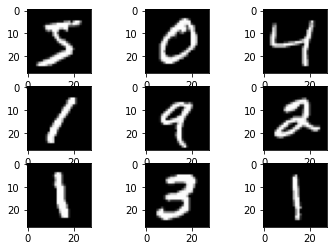

[5 0 4 1 9 2 1 3 1]


In [25]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# Load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# Plot first 9 images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
 
plt.show()

# Print the first 9 labels
print(trainy[:9])

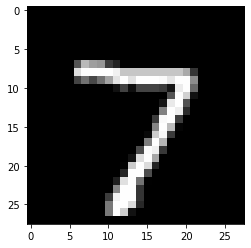

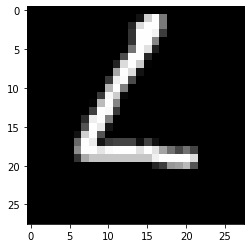

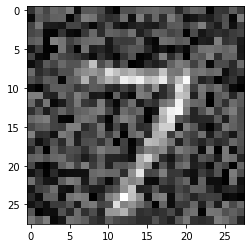

In [26]:
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from scipy.ndimage import rotate
import cv2

# Load train and test dataset
def load_dataset():

	  # Load dataset
	  (trainX, trainY), (testX, testY) = mnist.load_data()
	 
	  # Reshape dataset to have a single channel
	  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	  testX = testX.reshape((testX.shape[0], 28, 28, 1))
   
	  # One hot encode target values
	  trainY = to_categorical(trainY)
	  testY = to_categorical(testY)
   
	  trainX = trainX.astype('float32')
	  testX = testX.astype('float32')
   
	  trainX = trainX / 255.0
	  testX = testX / 255.0

	  return trainX, trainY, testX, testY

# Load train and test dataset
def load_rotated_dataset(percent_rotated):
	  
		# Load dataset
	  (trainX, trainY), (testX, testY) = mnist.load_data()
	  
		# Reshape dataset to have a single channel
	  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	  testX = testX.reshape((testX.shape[0], 28, 28, 1))
   
	  # One hot encode target values
	  trainY = to_categorical(trainY)
	  testY = to_categorical(testY)
   
	  trainX = trainX.astype('float32')
	  testX = testX.astype('float32')
	 
		# Transformation of a percentage of the test data by a 180 degree angle
	  for i in range(0,round(testX.shape[0]*(percent_rotated/100))):
	  		testX[i,:,:]= rotate(testX[i,:,:], angle=180)

	  trainX = trainX / 255.0
	  testX = testX / 255.0

	  return trainX, trainY, testX, testY

# Load train and test dataset
def load_noisy_dataset(percent_noisy):
	  
		# Load dataset
	  (trainX, trainY), (testX, testY) = mnist.load_data()
	  
		# Reshape dataset to have a single channel
	  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	  testX = testX.reshape((testX.shape[0], 28, 28, 1))
   
	  # One hot encode target values
	  trainY = to_categorical(trainY)
	  testY = to_categorical(testY)
   
	  trainX = trainX.astype('float32')
	  testX = testX.astype('float32')
	 
		# Transformation of a percentage of the test data with noise
	  for i in range(0,round(testX.shape[0]*(percent_noisy/100))):
				# Generate Gaussian noise
	  		gauss = np.random.normal(0,1000,testX[i,:,:].size)
	  		gauss = gauss.reshape(testX[i,:,:].shape[0],testX[i,:,:].shape[1],testX[i,:,:].shape[2]).astype('uint8')				
	  		testX[i,:,:] = testX[i,:,:] + gauss
		 
	  trainX = trainX / 255.0
	  testX = testX / 255.0

	  return trainX, trainY, testX, testY
 
trainX, trainY, testX, testY = load_dataset()
trainX2, trainY2, testX2, testY2 = load_rotated_dataset(50) # 50 percent of test data is rotated by 90 degrees
trainX3, trainY3, testX3, testY3 = load_noisy_dataset(50) # 50 percent of test data is noisy

plt.imshow(np.squeeze(testX[0,:,:]), cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(np.squeeze(testX2[0,:,:]), cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(np.squeeze(testX3[0,:,:]), cmap=plt.get_cmap('gray'))
plt.show()

In [27]:
# Define CNN model
def define_model():
  
	  model = Sequential()
	  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	  model.add(MaxPooling2D((2, 2)))
	  model.add(Flatten())
	  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	  model.add(Dense(10, activation='softmax'))
   
	  # Compile model
	  opt = SGD(learning_rate=0.01, momentum=0.9)
	  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
   
    # Visualize model
	  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
   
	  return model


# Evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):

	  scores, histories = list(), list()
   
	  # Prepare cross validation
	  kfold = KFold(n_folds, shuffle=True, random_state=1)
   
	  # Enumerate splits
	  for train_ix, test_ix in kfold.split(dataX):
		 
      # Define model
		  model = define_model()
		
      # Select rows for train and test
		  trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
	
  	  # Fit model
		  history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

		  # Evaluate model
		  _, acc = model.evaluate(testX, testY, verbose=0)
		  print('> %.3f' % (acc * 100.0))
    
		  # Stores scores
		  scores.append(acc)
		  histories.append(history)
	  return scores, histories    

In [28]:
# Plot diagnostic learning curves
def summarize_diagnostics(histories):

	  for i in range(len(histories)):
     
		  # Plot loss
		  plt.subplot(2, 1, 1)
		  plt.title('Cross Entropy Loss')
		  plt.plot(histories[i].history['loss'], color='blue', label='train')
		  plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    
		  # Plot accuracy
		  plt.subplot(2, 1, 2)
		  plt.title('Classification Accuracy')
		  plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		  plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
      
	  plt.show()
   
def summarize_performance(scores):
	  # Print summary
	  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	  # Box and whisker plots of results
	  plt.boxplot(scores)
	  plt.show()

In [29]:
# Run the test harness for evaluating a model
def run_test_harness():

	  # Load dataset
	  trainX, trainY, testX, testY = load_dataset()
	
    # Rvaluate model
	  scores, histories = evaluate_model(trainX, trainY)
	
    # Learning curves
	  summarize_diagnostics(histories)
	
    # Summarize estimated performance
	  summarize_performance(scores)

def run_test_harness_2(percentage_rotated):

	  # Load dataset
	  trainX, trainY, testX, testY = load_rotated_dataset(percentage_rotated)
	
    # Rvaluate model
	  scores, histories = evaluate_model(trainX, trainY)
	
    # Learning curves
	  summarize_diagnostics(histories)
	
    # Summarize estimated performance
	  summarize_performance(scores)

def run_test_harness_3(percentage_noisy):

	  # Load dataset
	  trainX, trainY, testX, testY = load_noisy_dataset(percentage_noisy)
	
    # Rvaluate model
	  scores, histories = evaluate_model(trainX, trainY)
	
    # Learning curves
	  summarize_diagnostics(histories)
	
    # Summarize estimated performance
	  summarize_performance(scores)

> 98.650
> 98.675
> 98.525
> 98.875
> 98.775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


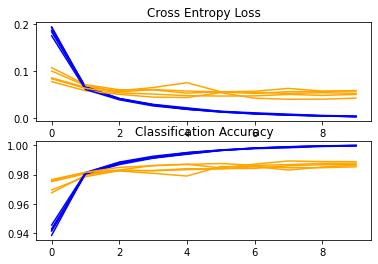

Accuracy: mean=98.700 std=0.118, n=5


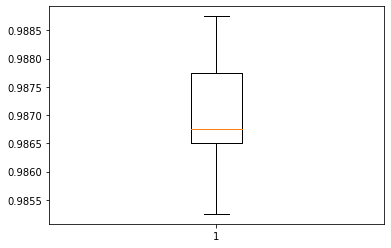

In [30]:
run_test_harness()

> 98.325
> 98.642
> 98.708
> 98.758
> 98.700


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


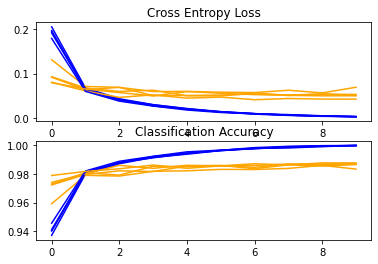

Accuracy: mean=98.627 std=0.155, n=5


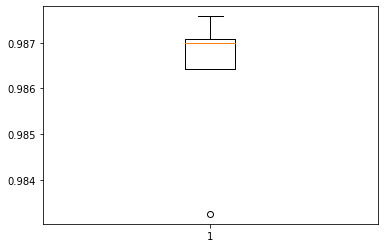

In [34]:
run_test_harness_2(100)

> 98.492
> 98.692
> 98.650
> 98.742
> 98.758


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


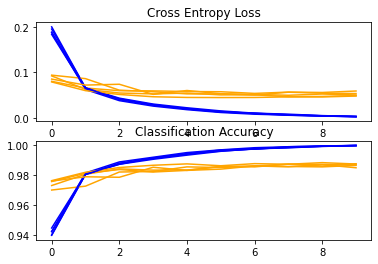

Accuracy: mean=98.667 std=0.095, n=5


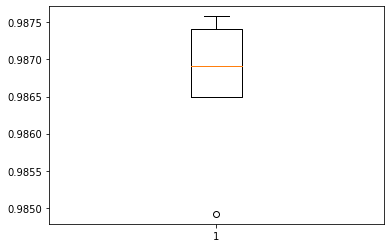

In [33]:
run_test_harness_3(100)